**Neural Machine Translation**

In this Ipython notebook, I will guide you step by step to work on Neural Machine Translation. As a part of this project, I have worked on English to Hindi Machine Translation by using LSTM Architecture on Keras Framework. 

**NOTE**: 

None of the code is plagiarized from any of the open source materials. Few functions are conventional statements while using keras framework and have been directly refered from its documentation. Other than that, I have mentioned the reference if I have taken help from any of the blogs/tutorials.   

**Step 1 : Importing libraries and exploring the dataset.** 

---





For English-Hindi Translation, I'll be making use of IIT Bombay English-Hindi Corpus. Link to download the dataset: https://drive.google.com/open?id=15yNTXYb65oz43nn9PIu6kyp792rr_yZ5

We'll also be needing Word2Vec Glove Embeddings which can be easily downloaded from here: http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
import numpy as np
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Bidirectional, RepeatVector, Concatenate, Dot, Lambda
from keras.callbacks import ModelCheckpoint
from keras.models import Input, Model
import keras.backend as K
from sklearn.model_selection import train_test_split
import time
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
df = pd.read_excel('gdrive/My Drive/Hi-En-Parallel_Corpus.xlsx')

In [0]:
df.head()


,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


On exploring the dataset, I found a lot of irregularities. Some data items were missing while some only contained integer/float values. This makes the operations for our task very cumbersome and hence, we need to convert all the items to string data type. 

Also, next part is to find the length of longest hindi and english sentence. 

In [0]:
df['english_sentence'] = df['english_sentence'].astype(str)
df['hindi_sentence'] = df['hindi_sentence'].astype(str)

In [0]:
df.shape

(127607, 2)

In [0]:
max_eng_length = max(df['english_sentence'].apply(lambda x: len(x.split(' '))))
max_hindi_length = max(df['hindi_sentence'].apply(lambda x: len(x.split(' '))))
print(max_eng_length)
print(max_hindi_length)

398
418


As you can see that without any pre-processing, our length of the sentences in both the columns are really huge. 
The 1.2L data items need to be reduced to make our model less computationally expensive and without compromising the accuracy. 

For this project, I have tried to bring the training parameters to 75K to achieve the best accuracy with the available GPU.
To decide which items to be dropped, we'll find all the rows having vocab length greater than 25. 

We'll also apply few more tools to clean the data. 

In [0]:
count = 0
delete_rows = []
for i in range(0,df.shape[0]):
  len_eng = len(df['english_sentence'][i].split())
  len_hin = len(df['hindi_sentence'][i].split())
  if len_eng > 25 or len_hin > 25:
    delete_rows.append(i)
    count = count +1 
print(count)

29786


In [0]:
df = df.drop(delete_rows)

In [0]:
df.shape

(97821, 2)

In [0]:
df.drop_duplicates(inplace=True)

In [0]:
df.shape 

(95080, 2)

**Step 2: Data Pre-Processing**

---
As a part of this module we'll work separately on english and hindi sentences. 
We'll be pre-processing to do the following tasks:


*   Removing numbers and digits from both input and output data
*   Removing Whitespaces in the sentence (leading and trailing)
*   Converting the entire sentence to lowercase
*   Remove all kinds of punctiontion items like ',{&%$' from the sentence. 
*   Remove english words in the Hindi sentences










In [0]:
def clean_english_data(sentence):
  exclude = set(string.punctuation)
  remove_digits = str.maketrans('', '', string.digits)
  sentence = sentence.lower()
  sentence = ''.join(ch for ch in sentence if ch not in exclude)
  sentence = sentence.translate(remove_digits)
  sentence = sentence.strip()
  sentence = re.sub(" +", " ", sentence)
  return sentence

In [0]:
def clean_hindi_data(sentence):
        exclude = set(string.punctuation)
        remove_digits = str.maketrans('', '', string.digits)
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)

        sent_temp = ''
        for c in sentence:
            if c == ' ':
                sent_temp += c
            elif ord(u'\u0900') <= ord(c) <= ord(u'\u097F'):
                sent_temp += c
        sentence = sent_temp
      
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

In [0]:
X = [clean_english_data(x) for x in df.english_sentence.values]
Y = [clean_hindi_data(y) for y in df.hindi_sentence.values]

In [0]:
MAX_VOCAB = 30000

**Step 3: Tokenization and Padding**

---
As a part of this process we'll tokenize both the input and output. The important thing over here is the addition of the `<sos`>(START) and` <eos>`(END) tags on the output sequence. This is for our neural network to understand the sequence and when to break the processing in our architecture. 

Next step is to padd the tokens to the largest length of the sentence(which we have set to 25). We find that we get hindi length size to be 26(24+2). It's 24 because of removal of whitespaces in the previous step or else ideally it should have been 27(25+2). 

We also find the vocab size of our input and output data.


In [0]:
def tokenize(x,is_hindi = False):
    # Add sos and eos to the sentence
    tokenizer_input = Tokenizer(num_words=MAX_VOCAB)
    if is_hindi:
      target_input_sequences = []
      target_sequences = []
      for sentence in x:
        target_input_sequences.append('<sos> '+sentence)
        target_sequences.append(sentence+' <eos>')
      tokenizer_output = Tokenizer(num_words=30000)
      tokenizer_output.fit_on_texts(target_input_sequences+target_sequences)
      target_input_sequences = tokenizer_output.texts_to_sequences(target_input_sequences)
      target_sequences = tokenizer_output.texts_to_sequences(target_sequences)
      return target_input_sequences,target_sequences,tokenizer_output
    else:
      tokenizer_input = Tokenizer(num_words=30000) 
      tokenizer_input.fit_on_texts(x)
      input_sequences = tokenizer_input.texts_to_sequences(x)
      return input_sequences,tokenizer_input 

In [0]:
input_sequences, tokenizer_input = tokenize(X)
target_input_sequences,target_sequences, tokenizer_output = tokenize(Y,is_hindi=True)
print(len(target_input_sequences),"and ",len(target_sequences))

95080 and  95080


In [0]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    print("The max length is ",length)    
    padded_x = pad_sequences(x, maxlen = length, padding = 'post', truncating = 'post')
    return padded_x

In [0]:
input_sequences = pad(input_sequences)
target_input_sequences = pad(target_input_sequences)
target_sequences = pad(target_sequences)

input_num_words = len(tokenizer_input.word_index) + 1
target_num_words = len(tokenizer_output.word_index) + 1  

print("English vocab size: ", input_num_words)
print("Hindi vocab size: ", target_num_words)
print()
  
max_input_len = len(input_sequences[0])
max_target_len = len(target_sequences[0])

words_input = tokenizer_input.word_index
words_output = tokenizer_output.word_index


print("Length of longest English sentence: ", max_input_len)
print("Length of longest Hindi sentence: ", max_target_len)
print()

The max length is  25
The max length is  26
The max length is  26
English vocab size:  49253
Hindi vocab size:  47529

Length of longest English sentence:  25
Length of longest Hindi sentence:  26



**Step 4: Model Architecture**

---
Now let's dive into the most important part of our project. 

For this task, we initially create input and target word embedding matrix. We have chose glove file to be 6B.100d as 100 dimensions makes it easier and giving us approximately the same accuracy as 300d. 

We will be working with **Bi-Directional LSTM** as we need to make sure that the context of the output is maintained along with the sequence structure. This is the core advantage of using BiLSTM as it not only preserver information and data from past(like single unit LSTM) but also considers future data. The output structure will be closesly related to the context of input which is very essential while converting sentences from one language to another.


In [0]:
DIMENSIONS = 100
LSTM_UNITS = 256

In [0]:
word2Vec = {}
with open('gdrive/My Drive/glove.6B.100d.txt') as f:
  for line in f:
    line = line.split(' ')
    word = line[0]
    word2Vec[word] = line[1:]

In [0]:
input_embedding_matrix = np.zeros((input_num_words, DIMENSIONS))
for word, k in words_input.items():
  if k < input_num_words:
    embedding_vector = word2Vec.get(word)
    if embedding_vector is not None:
      input_embedding_matrix[k] = embedding_vector

In [0]:
target_embedding_matrix = np.zeros((target_num_words, DIMENSIONS))
for word, k in words_input.items():
  if k < target_num_words:
    embedding_vector = word2Vec.get(word)
    if embedding_vector is not None:
      target_embedding_matrix[k] = embedding_vector

Let's start creating our embedding input layer. We already have all the values set. We take the 2D input and convert it to a tensor shaped embedding matrix. In [7] we have everything that we wish to know about embedding layers and its importance.

In [0]:
embedding_input = Input(shape=(max_input_len,))
embedding_input_layer = Embedding(input_num_words, DIMENSIONS, weights=[input_embedding_matrix], trainable=True)
x = embedding_input_layer(embedding_input)

In Neural Machine Translation, it is been found that deeper architectures tends to have much better performance than a single unit neural network. In [8] the author goes on to explain why deeper architectures are much useful for NMT and goes on to suggest that variation of DeepBi-RNN with depth 8 performs the best. 
To keep the computational and understanding simpler, we will restrict ourselves to 2 units of Bi-LSTM to improve the performance over single unit Neural Nets. 

In [0]:
input_lstm1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))
input_lstm1_output = input_lstm1(x)

input_lstm2 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))
encoder_output = input_lstm2(input_lstm1_output)

In [0]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

**Attention**

---
Attention is needed so that the long sequences of the textual data can be processed with maximum precision. Repeat vector is used to repeat the same input vectors at every iteration with different hidden state. [6] and [9] gives us a complete theorectical background as to why the specific tanh and softmax functions are used in the process. Taken the help of [10] to code the attention on keras. 



In [0]:
atten_layer_repeat = RepeatVector(max_input_len)
atten_concatenate = Concatenate(axis=-1)
atten_dense1 = Dense(30, activation='tanh')
atten_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)

In [0]:
def attention_procedure(h, st_1):
  st_1 = atten_layer_repeat(st_1)
  x = atten_concatenate([h, st_1])
  x = atten_dense1(x)
  alphas = atten_dense2(x)
  context = attn_dot([alphas,h])
  return context

In [0]:
st_0 = Input(shape=(LSTM_UNITS,))
c_0 = Input(shape=(LSTM_UNITS,))
context_last_word_concat_layer = Concatenate(axis=2)

Decoding embedding layer at outpuut and Initiating the Model.
we feed the output of the first LSTM layer to input the second LSTM layer before finally applying the softmax activation function on the output. If we feed the softmax to the output of first LSTM unit, it won't give us great results. 

We also stack the tensors to get the output and feed it to the model function.




In [0]:
embedding_decoder_input = Input(shape=(max_target_len,))
embedding_decoder_layer = Embedding(target_num_words, DIMENSIONS, weights=[target_embedding_matrix], trainable=True)
decoder_x = embedding_decoder_layer(embedding_decoder_input)

s = st_0
c = c_0
outputs = []
decoder_lstm = LSTM(LSTM_UNITS, return_state=True)
decoder_dense_layer = Dense(target_num_words, activation='softmax')
for i in range(max_target_len):
  context = attention_procedure(encoder_output, s)

  selector = Lambda(lambda x: x[:, i:i+1])
  xt = selector(decoder_x)
  decoder_lstm_input = context_last_word_concat_layer([context, xt])
  
  
  decoder_lstm_output, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])

  
  decoder_output = decoder_dense_layer(decoder_lstm_output)
  outputs.append(decoder_output)

In [0]:
def stack_and_transpose(x):
  x = K.stack(x) 
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) 
  return x

In [0]:
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

model = Model(
  inputs=[
    embedding_input,
    embedding_decoder_input,
    st_0, 
    c_0,
  ],
  outputs=outputs
)

**Step 5: Training**

---
Finally it's time to train the network we created in the above steps. We make the callback functions to regularly save our progress and then train our LSTM model.

We have used sparse_categorical_crossentropy as we have taken the target to be integers and not one-hot vectors. [11] gives us an idea as to how to how to fine tune the hyperparameters. For our project, rms_prop proved to be a better optimizer than Adam and hence, accepted in our training model. 

We split train-test 80-20 and then train our neural network. 


In [0]:
from keras.callbacks import ModelCheckpoint

filepath="/content/gdrive/My Drive/Checkpoints/weights-{epoch:02d}-{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                               verbose=1, mode='max')
callbacks_list = [checkpoint]

In [0]:
from keras.callbacks import *
from keras.models import load_model

model.load_weights('/content/gdrive/My Drive/Checkpoints/weights-11-0.692.hdf5')


In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

z = np.zeros((len(target_sequences), LSTM_UNITS))
r = model.fit(
  [input_sequences, target_input_sequences, z, z], target_sequences.reshape(target_sequences.shape[0],target_sequences.shape[1], 1),
  batch_size=128,
  epochs=10,
  validation_split=0.2,
  verbose=1,
  callbacks=callbacks_list,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 76064 samples, validate on 19016 samples
Epoch 1/10
76064/76064 [==============================] - 329s 4ms/step - loss: 1.6693 - acc: 0.7346 - val_loss: 2.0387 - val_acc: 0.6928

Epoch 00001: saving model to /content/gdrive/My Drive/Checkpoints/weights-01-0.693.hdf5
Epoch 2/10
76064/76064 [==============================] - 318s 4ms/step - loss: 1.6059 - acc: 0.7439 - val_loss: 2.0437 - val_acc: 0.6938

Epoch 00002: saving model to /content/gdrive/My Drive/Checkpoints/weights-02-0.694.hdf5
Epoch 3/10
76064/76064 [==============================] - 317s 4ms/step - loss: 1.5524 - acc: 0.7521 - val_loss: 2.0397 - val_acc: 0.6945

Epoch 00003: saving model to /content/gdrive/My Drive/Checkpoints/weights-03-0.694.hdf5
Epoch 4/10
76064/76064 [==============================] - 316s 4ms/step - loss: 1.4932 - acc: 0.7608 - val_loss: 2.0416 - val_acc: 0.6956

Epoch 00004: saving model to /content/gdrive/My Drive/Checkpoints/weights-04-0.696.hdf5
Epoch 5/10
76064/76064 [==================

As you can see above that we achieved a training accuracy of 80.21 % and validation accuracy of **69.4%** for our dataset. We trained it for 20 epochs (weight till 10th epoch loaded from the latest checkpoint and then trained for another 10 epochs) to achieve to this accuracy and as you can see there is no scope for improvement in the future epochs, we conclude our training stage. 

Below is a small visualization of our training model for the last 10 epochs. 

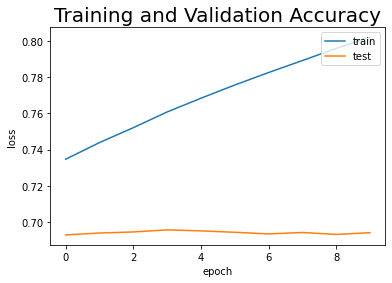

In [0]:
 plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('Training and Validation Accuracy',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
model.save('/content/gdrive/My Drive/Checkpoints/translator.h5')

In [0]:
model.save_weights('/content/gdrive/My Drive/Checkpoints/translator1.h5')

**Encoder and Decoder**

Finally we test our model and initiate our encoder and decoder functions. We make the predictions by giving the data to the encoder and receiving the output at decoder. 

A step wise end-end process is being carried out for our neural architecture and translation is performed. 

In [0]:
encoder_outputs_as_input = Input(shape=(max_input_len, LSTM_UNITS * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_decoder_layer(decoder_inputs_single)

context = attention_procedure(encoder_outputs_as_input, st_0)


decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])





o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[st_0, c_0])
decoder_outputs = decoder_dense_layer(o)






decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    st_0, 
    c_0
  ],
  outputs=[decoder_outputs, s, c]
)


In [0]:
encoder_model = Model(embedding_input, encoder_output)

In [0]:
idx2word = {v:k for k, v in words_output.items()}

In [0]:
def prediction(input_seq):

  enc_out = encoder_model.predict([[input_seq]])

  target_seq = np.zeros((1, 1))
  

  target_seq[0, 0] = words_output['sos']

  eos = words_output['eos']



  s = np.zeros((1, LSTM_UNITS))
  c = np.zeros((1, LSTM_UNITS))


  output_sentence = []
  for _ in range(max_target_len):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    idx = np.argmax(o.flatten())

    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word[idx]
      output_sentence.append(word)


    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

In [0]:
import random
predictions_inputs = []
true_outputs = []
count = 0
for i in range(0,5):
  predictions_inputs.append(df['english_sentence'][i])
  true_outputs.append(df['hindi_sentence'][i])
  count += 1
predictions_inputs = tokenizer_input.texts_to_sequences(predictions_inputs)
predictions_inputs = pad_sequences(predictions_inputs, maxlen=max_input_len)

**Step 6: Translation**

---


Finally we are able to test our NMT architecture. I have provided few samples below. Before that a bit of processing is needed to segregate our actual and predicted outputs. 

On careful observation of various samples, the model seems to be performing well for short sentences. For long sentences, even if the grammatical structure is not completely accurate, it still retains the context of the input. The results are encouraging and can be improved in the ways explained towards the end. 

In [0]:
true_outputs = []
true_inputs = []
df2 = df['hindi_sentence'].tail(n=19016).tolist()
df3 = df['english_sentence'].tail(n=19016).tolist()
true_outputs.extend(df2)
true_inputs.extend(df3)
print(true_inputs[0])
print(true_outputs[0])

I started my journey in California
मैंने अपना सफ़र कैलिफोर्निया से शुरू किया


In [0]:
test_input = input_sequences[-19016:]
print(test_input[0])

[  16  159   64 1247    5 3342    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [0]:
predicted_text = []
count = 0
for i in test_input:
  predicted_output = prediction(i)
  print(count)
  count = count + 1
  predicted_text.append(predicted_output)
print(predicted_text[0])

Streaming output truncated to the last 5000 lines.
14018
14019
14020
14021
14022
14023
14024
14025
14026
14027
14028
14029
14030
14031
14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
1

In [0]:
with open('/content/gdrive/My Drive/output.txt', 'w') as f:
  for row in predicted_text:
    f.write(str(row) + '\n')

In [0]:
import random
for i in range(0,5):
  random_integer = random.randint(0,100)
  print('English Sentence is')
  print(true_inputs[random_integer])
  print('---------------------')
  print('Actual Hindi Sentence')
  print(true_outputs[random_integer])
  print('---------------------')
  print('Predicted Hindi Sentence')
  print(predicted_text[random_integer])

English Sentence is
Its main entrance is from Lahore gate.
---------------------
Actual Hindi Sentence
लाहौर गेट इसका मुख्य प्रवेशद्वार है।
---------------------
Predicted Hindi Sentence
इसका मुख्य लाहौर गेट प्रधान लाहौर से किमी है
English Sentence is
in other essays collection of different views,thoughts,pictured,speeches far sight are important.
---------------------
Actual Hindi Sentence
अन्य निबंध में संकल्पिता तथा विविध संकलनों में स्मारिका स्मृति चित्र संभाषण संचयन दृष्टिबोध उल्लेखनीय हैं।
---------------------
Predicted Hindi Sentence
अन्य विभिन्न स्थानों पर विभिन्न प्रकार की सामाजिक दृष्टि से उनका महत्वपूर्ण है
English Sentence is
Hanuman is an ideal devotee, and is always ready to assist Rama and serve him.
---------------------
Actual Hindi Sentence
हनुमान एक आदर्श भक्त हैं वे राम की सेवा के लिये अनुचर के समान सदैव तत्पर रहते हैं।
---------------------
Predicted Hindi Sentence
हनुमान को आदर्श में भगवान् जाने के लिए हनुमान हैं और रावण का वध करते हैं
English Sentence is
I start

**Step 7: Evaluation** 

---
Finally we evaluate the performance of our model using BLEU metric. We evaluate the performance for the actual and predicted sentences upto 4-gram and giving us an accuracy of **0.75** and an average of **0.59.**


In [0]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_model(actual,predicted):
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
evaluate_model(true_outputs,predicted_text)


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.324522
BLEU-2: 0.569668
BLEU-3: 0.713466
BLEU-4: 0.754764


**Future Scope**

---
The above work gives us satisfactory results but still lacks on few aspects. It's important to atleast consider them for our evaluation so that those points could be improved in future. A majority of them lies in the pre-processing and handling of the data.

*   Hindi Tokenizer can be improved greatly if we use an external library for that. The pre-processing and tokenizing of hindi sentences can be done much more effecently by using the Indic-nlp library : https://github.com/anoopkunchukuttan/indic_nlp_library
*   A lot of sentences had dates and years which were removed during the pre-processing which broke the context of then sentences. Work can be done to make the dates machine readable(Since, the instructions specified to remove digits, this part was not possible).
*   The hyperparameters can still be fine tuned by vigorous testing to improve the performance. 
*   GPU constraints allowed us to train on only 76K parameters. Full use of the dataset might improve the performance. 
*   Accuracy for long sentences is still not satisfactory and needs a better way to handle it. A possible approach is to reduce the batch size and increase the deep layer architecture. 
*   Shifting the architecture to Pytorch framework might improve the overall results as it has a better attention mechansim than keras.  











**REFFERENCES:**

---
1.   https://towardsdatascience.com/neural-machine-translation-15ecf6b0b
2.   https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
3.   https://pravn.wordpress.com/2017/11/14/bahdanau-attention/
4.   https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
5.   https://towardsdatascience.com/implementing-neural-machine-translation-with-attention-using-tensorflow-fc9c6f26155f
6. https://medium.com/@joealato/attention-in-nlp-734c6fa9d983
7.   https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
8. https://www.aclweb.org/anthology/W17-4710.pdf
9. https://blog.floydhub.com/attention-mechanism/
10. https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
11. https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046









